In [120]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import re
from geopy.distance import vincenty
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
% matplotlib inline
import cartopy.crs as ccrs
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from time import time
from tsfresh import extract_relevant_features, extract_features
import xgboost as xgb
import warnings
from sklearn.externals import joblib

In [2]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
accdnt_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_wndw.csv', parse_dates=['Timestamp'])

In [4]:
accdnt_windows['y'] = 1

In [5]:
accdnt_free_windows = pd.read_csv('../data/PeMS/Incidents/work_folder/year_accdnt_free_wndw.csv', parse_dates=['Timestamp'])
# accdnt_free_windows['IncidentID'] = 0

In [6]:
accdnt_free_windows['y'] = 0

In [218]:
def plot_window(data, chrct = 'Total Flow'):
    formatter = DateFormatter('%H:%M')
      
    times = pd.date_range(start=data.Timestamp - dt.timedelta(minutes=40), periods=16, freq='300s')
    x_min = times[0] - dt.timedelta(minutes=4)
    x_max = times[-1] + dt.timedelta(minutes=5)
#     cols = [col for col in data.columns if chrct in col]
    cols = [col for col in data.index if chrct in col and 'Next' not in col]
    n_cols = [col for col in data.index if chrct in col and 'Next' in col]
#     data[cols].plot(linestyle='--', label = 'Upstream')
#     data[n_cols].plot(label = 'Downstream')
    plt.plot(times, data[cols].as_matrix(), linestyle='--', label = 'Upstream')
    plt.plot(times, data[n_cols].as_matrix(), label = 'Downstream')
#     plt.axvline(data.Timestamp)
    plt.grid()
    plt.legend()
    plt.ylabel(chrct + ', cars/5min')
    plt.xticks(rotation=45)
    plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
    plt.xlim(x_min, x_max)
    plt.savefig('window.png', lw=4, dpi=600)
    plt.show()

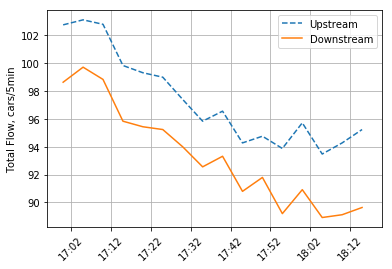

In [58]:
plot_window(accdnt_free_windows.iloc[178])

In [9]:
common_cols = ['ID_Prev', 'ID_Next', 'Timestamp', 'Latitude_Next', 'Longitude_Next', 'Latitude_Prev', 'Longitude_Prev',
               'Lanes_Prev', 'Lanes_Next',
             'Avg Occupancy_0',
       'Avg Occupancy_1', 'Avg Occupancy_2', 'Avg Occupancy_3',
       'Avg Occupancy_4', 'Avg Occupancy_5', 'Avg Occupancy_6',
       'Avg Occupancy_7', 'Avg Occupancy_8', 'Avg Occupancy_9',
       'Avg Occupancy_10', 'Avg Occupancy_11', 'Avg Occupancy_12',
       'Avg Occupancy_13', 'Avg Occupancy_14', 'Avg Occupancy_15',
       'Total Flow_0',
       'Total Flow_1', 'Total Flow_2', 'Total Flow_3', 'Total Flow_4',
       'Total Flow_5', 'Total Flow_6', 'Total Flow_7', 'Total Flow_8',
       'Total Flow_9', 'Total Flow_10', 'Total Flow_11', 'Total Flow_12',
       'Total Flow_13', 'Total Flow_14', 'Total Flow_15',
       'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15',
        'Next Avg Occupancy_0', 'Next Avg Occupancy_1','Next Avg Occupancy_2',
        'Next Avg Occupancy_3', 'Next Avg Occupancy_4', 'Next Avg Occupancy_5',
        'Next Avg Occupancy_6', 'Next Avg Occupancy_7', 'Next Avg Occupancy_8',
             'Next Avg Occupancy_9','Next Avg Occupancy_10','Next Avg Occupancy_11',
             'Next Avg Occupancy_12','Next Avg Occupancy_13','Next Avg Occupancy_14',
             'Next Avg Occupancy_15','Next Total Flow_0','Next Total Flow_1',
             'Next Total Flow_2','Next Total Flow_3','Next Total Flow_4',
             'Next Total Flow_5','Next Total Flow_6','Next Total Flow_7',
             'Next Total Flow_8','Next Total Flow_9','Next Total Flow_10',
             'Next Total Flow_11','Next Total Flow_12','Next Total Flow_13',
             'Next Total Flow_14','Next Total Flow_15','Next Avg Speed_0',
             'Next Avg Speed_1','Next Avg Speed_2','Next Avg Speed_3',
             'Next Avg Speed_4','Next Avg Speed_5','Next Avg Speed_6',
             'Next Avg Speed_7','Next Avg Speed_8','Next Avg Speed_9',
             'Next Avg Speed_10','Next Avg Speed_11','Next Avg Speed_12',
             'Next Avg Speed_13','Next Avg Speed_14','Next Avg Speed_15',
              'y']

In [134]:
dataset = pd.concat((accdnt_windows[common_cols], accdnt_free_windows[common_cols]), axis=0).reset_index(drop=True)

In [16]:
dataset.y.mean()

0.4758389058670459

In [17]:
dataset[dataset.y==1].shape

(15726, 108)

In [44]:
weather = pd.read_csv('../data/Weather/weather.csv', parse_dates=["Date"])

In [45]:
weather['Date'] = weather.Date.dt.date

In [46]:
dataset['Date'] = dataset.Timestamp.dt.date

In [47]:
dataset = dataset.merge(weather, how='left', on='Date').drop(columns='Date')

In [135]:
dataset['Hour'] = dataset.Timestamp.dt.hour

In [136]:
dataset = dataset.drop(index=dataset[(dataset['Hour']<6) | (dataset['Hour']>21)].index).reset_index(drop=True)

In [137]:
np.random.seed=442
dataset = dataset.reindex(index=np.random.permutation(dataset.index))

In [138]:
dataset['Width_change'] = dataset.apply(lambda x: 1 if x.Lanes_Prev==x.Lanes_Next else 0, axis=1)

In [139]:
dataset.reset_index(drop=True, inplace=True)

In [233]:
dataset = pd.get_dummies(dataset, columns=['Hour'], prefix='hour')

In [127]:
non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]

In [19]:
dataset.to_csv('../data/PeMS/Incidents/work_folder/windows.csv', index=False)

In [22]:
dataset= pd.read_csv('../data/PeMS/Incidents/work_folder/windows.csv', parse_dates=['Timestamp'])

In [12]:
def feature_extraction(dataset):
    cols = [col for col in dataset.columns if 'Avg' in col or 'Total' in col]
    dataset = dataset[cols]
    t_labels = np.arange(len(cols)/3, dtype=int)
    t_labels = np.concatenate((t_labels,t_labels,t_labels))
    aux_labels = pd.DataFrame({'val_name': cols, 't': t_labels})
    long = dataset.reset_index().melt(id_vars=['index'], var_name='series_param', value_name='value')
    long = long.merge(aux_labels, how='left', left_on='series_param', right_on='val_name').drop('val_name', axis=1)
    long['series_param'] = long['series_param'].apply(lambda row: row.split('_')[0])
    long = long.rename(columns={'index': 'ID'})[['ID', 't', 'series_param', 'value']]
    extracted = extract_features(long, column_id='ID', column_sort='t', column_kind='series_param', column_value='value', n_jobs=4)
    # try imputation
    extracted.dropna(axis=1, how='any', inplace=True)
    return extracted

In [13]:
def batch_extraction(dataset, b_size):
    m=dataset.shape[0]
    result=pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = feature_extraction(dataset.loc[i:i+b_size-1])
#         result = pd.concat((result, crnt_ftrs))
        crnt_ftrs.to_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i), index=False)
    print('EGOR virubajjj!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


In [14]:
rnm_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

In [15]:
dct = dict()
for col in rnm_cols:
    dct['Next_'+col] = 'Next '+col

In [16]:
dataset.rename(columns=dct, inplace=True)

In [18]:
batch_extraction(dataset, 1000)

Feature Extraction: 100%|██████████| 20/20 [03:16<00:00,  9.81s/it]


FileNotFoundError: [Errno 2] No such file or directory: '../data/PeMS/Incidents/work_folder/extracted/extracted_0.csv'

In [129]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y']), test['y'], stratify=test.y, test_size=.2)

In [236]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6635275652344517
f1 = 0.6567940764458675
CM = [[3482 1431]
 [1999 3282]]


In [237]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.7032568177359231
f1 = 0.6977720051953242
CM = [[3677 1236]
 [1789 3492]]


In [238]:
proba = forest.predict_proba(te_X)

In [239]:
fpr, tpr, _ = roc_curve(te_y, proba[:,1])

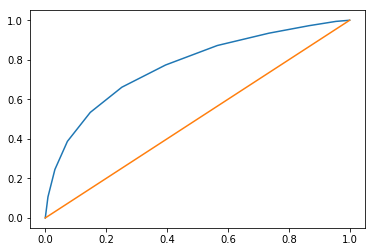

In [240]:
plt.plot(fpr, tpr)
plt.plot([0, 1],[0,1])
plt.show()

In [15]:
def batch_concatenation(dataset, b_size):
    m=dataset.shape[0]
    result = pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = pd.read_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted/extracted_{0:d}.csv'.format(i))
        crnt_ftrs = crnt_ftrs.replace([np.inf, -np.inf], np.NaN)
        crnt_ftrs.dropna(axis=1, inplace=True)
        result = pd.concat((result, crnt_ftrs), axis=0)
    result = result.dropna(axis=1).reset_index(drop=True)
    non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]
    result = pd.concat((result, dataset[non_series_cols]), axis=1)
    return result

In [16]:
test = batch_concatenation(dataset,1000)

In [17]:
test.drop(columns='Timestamp', inplace=True)

In [18]:
test.to_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted.csv', index=False)

In [2]:
test = pd.read_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted.csv')

In [19]:
tr_X, te_X, tr_y, te_y = train_test_split(test.drop(columns=['y', 'IncidentID']), test['y'], stratify=test.y)

In [20]:
scaler = StandardScaler()

In [21]:
tr_X = scaler.fit_transform(tr_X)

In [22]:
te_X = scaler.transform(te_X)

In [29]:
logreg = LogisticRegression()
logreg.fit(tr_X, tr_y)
print('acc =', logreg.score(te_X, te_y))
predict = logreg.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict))

acc = 0.6731410633706102
f1 = 0.6624797406807131
CM = [[3592 1321]
 [2011 3270]]


In [30]:
forest = RandomForestClassifier(random_state=14)
forest.fit(tr_X, tr_y)
print('acc =', forest.score(te_X, te_y))
predict = forest.predict(te_X)
F1_score = f1_score(te_y, predict)
print('f1 =', F1_score)
print('CM =', confusion_matrix(te_y, predict, labels=[0,1]))

acc = 0.6783402001177163
f1 = 0.6674104878790952
CM = [[3625 1288]
 [1991 3290]]


In [145]:
grid_params = {'n_estimators': [10, 100, 200],
               'max_depth' : [2, 3, 5],  
               'min_samples_leaf': [2, 5, 10]
}
grd_search = GridSearchCV(forest, grid_params,
                          scoring={'f1_score' : make_scorer(f1_score)},
                          refit='f1_score',
                          cv=5, return_train_score=True, n_jobs=-1, verbose=2)

In [264]:
grd_search.fit(tr_X, tr_y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=10 ................
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.0s
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   3.1s
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] max_depth=2, min_samples_leaf=2, n_estimators=100 ...............
[CV] . max_depth=2, min_samples_leaf=2, n_estimators=10, total=   0.4s
[CV] max_depth=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.3s


[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   6.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.6s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.7s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=100 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.9s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=5, n_estimators=200, total=   7.0s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.1s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[CV]  max_depth=2, min_samples_leaf=10, n_estimators=100, total=   3.3s
[CV] max_depth=2, min_samples_leaf=10, n_estimators=200 ..............
[

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=14, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 200], 'max_depth': [2, 3, 5], 'min_samples_leaf': [2, 5, 10]},
       pre_dispatch='2*n_jobs', refit='f1_score', return_train_score=True,
       scoring={'f1_score': make_scorer(f1_score)}, verbose=2)

In [265]:
grd_search.best_score_

0.5738945649022463

In [186]:
for col in dataset.columns:
    print(col)

IncidentID
Latitude
Longitude
Avg Occupancy_0
Avg Occupancy_1
Avg Occupancy_2
Avg Occupancy_3
Avg Occupancy_4
Avg Occupancy_5
Avg Occupancy_6
Avg Occupancy_7
Avg Occupancy_8
Avg Occupancy_9
Avg Occupancy_10
Avg Occupancy_11
Avg Occupancy_12
Avg Occupancy_13
Avg Occupancy_14
Avg Occupancy_15
Avg Speed_0
Avg Speed_1
Avg Speed_2
Avg Speed_3
Avg Speed_4
Avg Speed_5
Avg Speed_6
Avg Speed_7
Avg Speed_8
Avg Speed_9
Avg Speed_10
Avg Speed_11
Avg Speed_12
Avg Speed_13
Avg Speed_14
Avg Speed_15
Total Flow_0
Total Flow_1
Total Flow_2
Total Flow_3
Total Flow_4
Total Flow_5
Total Flow_6
Total Flow_7
Total Flow_8
Total Flow_9
Total Flow_10
Total Flow_11
Total Flow_12
Total Flow_13
Total Flow_14
Total Flow_15
y
hour__6
hour__7
hour__8
hour__9
hour__10
hour__11
hour__12
hour__13
hour__14
hour__15
hour__16
hour__17
hour__18
hour__19
hour__20
hour__21
Avg Occupancy_0_sq
Avg Occupancy_1_sq
Avg Occupancy_2_sq
Avg Occupancy_3_sq
Avg Occupancy_4_sq
Avg Occupancy_5_sq
Avg Occupancy_6_sq
Avg Occupancy_7_sq
Av

In [154]:
fignum = 1
def score_dataset(dataset, drop_features=[], cv=5):
    global fignum
    drop_cols = ['y', 'Timestamp', 'ID_Prev', 'ID_Next'] + drop_features #, 'Longitude', 'Latitude'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
    print(fignum)    
    print('Logistic regression')
    logreg = LogisticRegression()
    cv_res = cross_validate(logreg, tr_X, tr_y, n_jobs=-1, cv=cv, scoring=['f1', 'roc_auc', 'precision', 'recall'])# scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1'].mean()
    F1_var = cv_res['test_f1'].std()
    RA_score = cv_res['test_roc_auc'].mean()
    RA_var = cv_res['test_roc_auc'].std()
    P_score = cv_res['test_precision'].mean()
    P_var = cv_res['test_precision'].std()
    R_score = cv_res['test_recall'].mean()
    R_var = cv_res['test_recall'].std()
    
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    print('{}-fold CV ROC AUC = {}, std = {}'.format(cv, RA_score, RA_var))
    print('{}-fold CV P = {}, std = {}'.format(cv, P_score, P_var))
    print('{}-fold CV R = {}, std = {}'.format(cv, R_score, R_var))
    logreg.fit(tr_X, tr_y)
    predict = logreg.predict(te_X)
    proba = logreg.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.savefig('../data/PeMS/Incidents/work_folder/figs/log/roc_auc_{}'.format(fignum), lw=4, dpi=600)
    plt.show()
    print()
    
    print('Random Forest')
    forest = RandomForestClassifier(random_state=14)  
    cv_res = cross_validate(forest, tr_X, tr_y, n_jobs=-1, cv=cv, scoring=['f1', 'roc_auc', 'precision', 'recall'])
    F1_score = cv_res['test_f1'].mean()
    F1_var = cv_res['test_f1'].std()
    RA_score = cv_res['test_roc_auc'].mean()
    RA_var = cv_res['test_roc_auc'].std()
    P_score = cv_res['test_precision'].mean()
    P_var = cv_res['test_precision'].std()
    R_score = cv_res['test_recall'].mean()
    R_var = cv_res['test_recall'].std()
    
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    print('{}-fold CV ROC AUC = {}, std = {}'.format(cv, RA_score, RA_var))
    print('{}-fold CV P = {}, std = {}'.format(cv, P_score, P_var))
    print('{}-fold CV R = {}, std = {}'.format(cv, R_score, R_var))
    forest.fit(tr_X, tr_y)
    predict = forest.predict(te_X)
    proba = forest.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.savefig('../data/PeMS/Incidents/work_folder/figs/rnd/roc_auc_{}'.format(fignum), lw=4, dpi=600)
    plt.show()
    fignum += 1
    print()
    return logreg, fpr, tpr


1
Logistic regression
5-fold CV f1 = 0.6273197339861951, std = 0.006259664409038999
5-fold CV ROC AUC = 0.7296367705231481, std = 0.0019959433583197194
5-fold CV P = 0.6992008524724667, std = 0.0056041919801480405
5-fold CV R = 0.5688728411507631, std = 0.007742692479994733
example CM = [[2702  763]
 [1425 1720]]


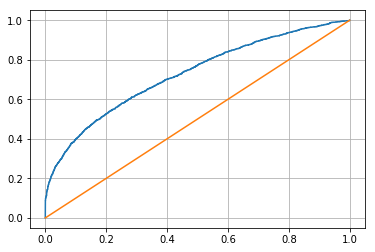

In [150]:
logreg, all_lfpr, all_ltpr = score_dataset(dataset)

1
Logistic regression
5-fold CV f1 = 0.44766940870584887, std = 0.012282405048180404
5-fold CV ROC AUC = 0.575182159192034, std = 0.006069642710239017
5-fold CV P = 0.5266649623356257, std = 0.006764740240150881
5-fold CV R = 0.3893945968684804, std = 0.015064622654359568
example CM = [[2368 1097]
 [1950 1195]]


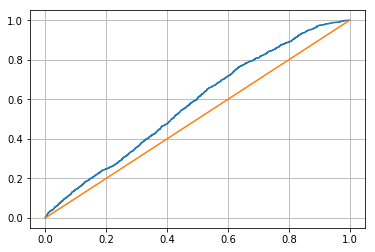

In [151]:
logreg, all_lfpr_m40, all_ltpr_m40 = score_dataset(dataset, [cc for cc in min_later_m40])

1
Logistic regression
5-fold CV f1 = 0.5678740606747633, std = 0.010691605459317726
5-fold CV ROC AUC = 0.6736770989369644, std = 0.012500006694358095
5-fold CV P = 0.6488279449979971, std = 0.014800476394794952
5-fold CV R = 0.5049668296916421, std = 0.010065816638818354
example CM = [[2560  905]
 [1547 1598]]


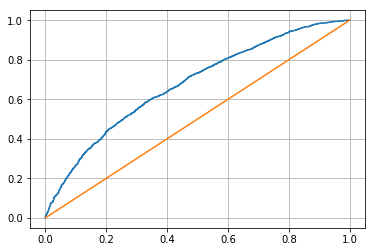

In [152]:
logreg, all_lfpr_m10, all_ltpr_m10 = score_dataset(dataset, [cc for cc in min_later_m10])

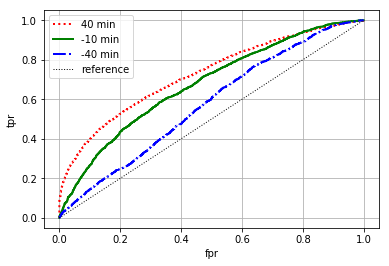

In [155]:
# plt.plot(fpr_m10, tpr_m10, label='5 min', linestyle='-', lw=2)
plt.plot(all_lfpr, all_ltpr, label='40 min', linestyle=':', lw=2, color='r')
# plt.plot(fpr20, tpr20, label='20 min', linestyle='-.', lw=2, color='g')
# plt.plot(fpr30, tpr30, label='30 min', linestyle='--', lw=2, color='b')
plt.plot(all_lfpr_m10, all_ltpr_m10, label='-10 min', linestyle='-', lw=2, color='g')
plt.plot(all_lfpr_m40, all_ltpr_m40, label='-40 min', linestyle='-.', lw=2, color='b')
plt.plot([0,1], [0,1], label='reference', linestyle=':', lw=1, color='black')
plt.grid()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.savefig('../data/PeMS/Incidents/work_folder/figs/log/roc_auc_sizes.png', lw=4, dpi=600)
plt.show()

# W/o weather data

## as is

1
Logistic regression
5-fold CV f1 = 0.6231951461764337, std = 0.009568952031715934
5-fold CV ROC AUC = 0.7290443793159153, std = 0.009078086915136964
5-fold CV P = 0.6950466971596084, std = 0.0069477556258659146
5-fold CV R = 0.5649011838733496, std = 0.012768837095696936
example CM = [[2682  783]
 [1350 1795]]


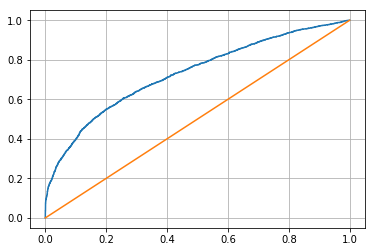


Random Forest
5-fold CV f1 = 0.6563753901570224, std = 0.00275424517492148
5-fold CV ROC AUC = 0.7636292236613138, std = 0.0029806056008635246
5-fold CV P = 0.7236537304453714, std = 0.0035713826798100786
5-fold CV R = 0.6005886521731716, std = 0.005665596855208305
example CM = [[2775  690]
 [1160 1985]]


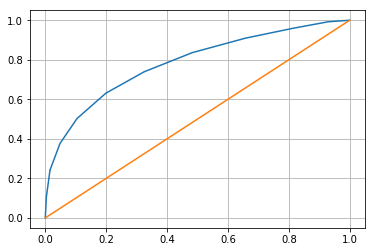

In [75]:
clf = score_dataset(dataset)

## w/o Next

In [20]:
Next_cols = ['Next Avg Occupancy_0','Next Avg Occupancy_1','Next Avg Occupancy_2',
             'Next Avg Occupancy_3','Next Avg Occupancy_4','Next Avg Occupancy_5',
             'Next Avg Occupancy_6','Next Avg Occupancy_7','Next Avg Occupancy_8',
             'Next Avg Occupancy_9','Next Avg Occupancy_10','Next Avg Occupancy_11',
             'Next Avg Occupancy_12','Next Avg Occupancy_13','Next Avg Occupancy_14',
             'Next Avg Occupancy_15','Next Total Flow_0','Next Total Flow_1',
             'Next Total Flow_2','Next Total Flow_3','Next Total Flow_4',
             'Next Total Flow_5','Next Total Flow_6','Next Total Flow_7',
             'Next Total Flow_8','Next Total Flow_9','Next Total Flow_10',
             'Next Total Flow_11','Next Total Flow_12','Next Total Flow_13',
             'Next Total Flow_14','Next Total Flow_15','Next Avg Speed_0',
             'Next Avg Speed_1','Next Avg Speed_2','Next Avg Speed_3',
             'Next Avg Speed_4','Next Avg Speed_5','Next Avg Speed_6',
             'Next Avg Speed_7','Next Avg Speed_8','Next Avg Speed_9',
             'Next Avg Speed_10','Next Avg Speed_11','Next Avg Speed_12',
             'Next Avg Speed_13','Next Avg Speed_14','Next Avg Speed_15']

2
Logistic regression
5-fold CV f1 = 0.6155211434746268, std = 0.00799466659572607
5-fold CV ROC AUC = 0.720146236648944, std = 0.008268181610412295
5-fold CV P = 0.6913795866099692, std = 0.008989101276672046
5-fold CV R = 0.5547248187681477, std = 0.00927803552808948
example CM = [[2669  796]
 [1383 1762]]


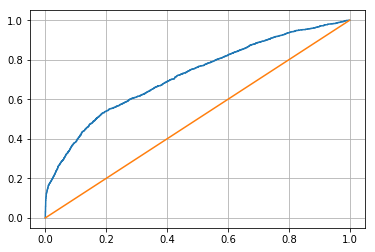


Random Forest
5-fold CV f1 = 0.6756483835741178, std = 0.009203652212604892
5-fold CV ROC AUC = 0.7807794502002244, std = 0.004214388691831696
5-fold CV P = 0.7365274228827158, std = 0.013713483355636534
5-fold CV R = 0.6241951549811047, std = 0.010146448825349833
example CM = [[2762  703]
 [1104 2041]]


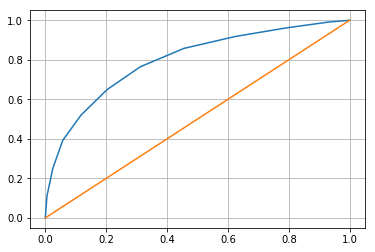

In [21]:
score_dataset(dataset, Next_cols)

## delta

In [22]:
for col in ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']:
    dataset[col] = dataset[col] - dataset['Next '+col]
    dataset[col + '_sq'] = (dataset[col] - dataset['Next '+col] )**2
    dataset.drop(columns='Next '+col, inplace=True)

sq_cols = [col for col in dataset.columns if '_sq' in col]

non_sq_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

5
Logistic regression
5-fold CV f1 = 0.5655769693375692, std = 0.004592617868637299
5-fold CV ROC AUC = 0.6703716788966112, std = 0.0023460746936875667
5-fold CV P = 0.6449983322362929, std = 0.005813324895804338
5-fold CV R = 0.5036172153363487, std = 0.006139411261011264
example CM = [[2568  897]
 [1588 1557]]


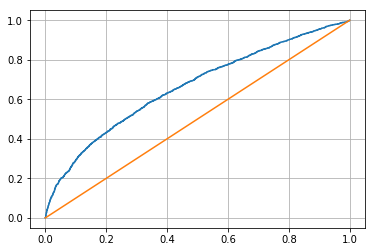


Random Forest
5-fold CV f1 = 0.6568835061625908, std = 0.006080428304869472
5-fold CV ROC AUC = 0.7619929822282788, std = 0.004307534986364607
5-fold CV P = 0.7137677502499968, std = 0.007959649399317743
5-fold CV R = 0.608536103936791, std = 0.010192175334065624
example CM = [[2709  756]
 [1207 1938]]


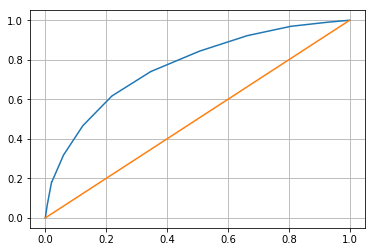

In [25]:
score_dataset(dataset, non_sq_cols)

## diff and sq diff

4
Logistic regression
5-fold CV f1 = 0.6042276130759221, std = 0.0057660813329905875
5-fold CV ROC AUC = 0.7090765460622382, std = 0.009737463754901298
5-fold CV P = 0.6875349330194942, std = 0.010291725447536674
5-fold CV R = 0.5390663361952712, std = 0.008411301353492173
example CM = [[2684  781]
 [1403 1742]]


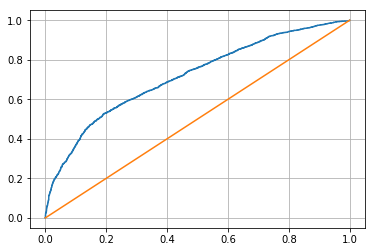


Random Forest
5-fold CV f1 = 0.6556482096696861, std = 0.011484074461378288
5-fold CV ROC AUC = 0.7625309113732216, std = 0.006069532981009013
5-fold CV P = 0.713520718930259, std = 0.006427228554936805
5-fold CV R = 0.6067088472473035, std = 0.018271806968585443
example CM = [[2695  770]
 [1123 2022]]


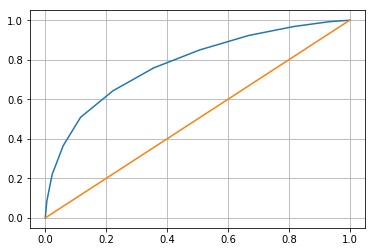

In [24]:
score_dataset(dataset)

# W/ weather data

## as is

6
Logistic regression
5-fold CV f1 = 0.6260252207859168, std = 0.007398861328744343
5-fold CV ROC AUC = 0.7306708271622799, std = 0.006847891521000731
5-fold CV P = 0.6944004547036818, std = 0.007986505973220486
5-fold CV R = 0.5700646415187536, std = 0.011673960505496326
example CM = [[2721  744]
 [1372 1773]]


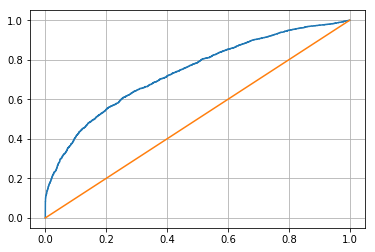


Random Forest
5-fold CV f1 = 0.6704716353605228, std = 0.008456101056510573
5-fold CV ROC AUC = 0.7762047972754405, std = 0.008970070861321178
5-fold CV P = 0.7315212456024947, std = 0.01353972182683169
5-fold CV R = 0.6189482267796789, std = 0.00865254238609766
example CM = [[2789  676]
 [1206 1939]]


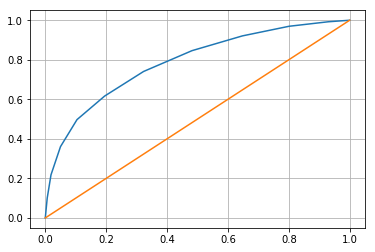

In [36]:
score_dataset(dataset)

## w/o Next

In [39]:
Next_cols = ['Next_Avg Occupancy_0', 'Next_Avg Occupancy_1', 'Next_Avg Occupancy_2', 'Next_Avg Occupancy_3',
         'Next_Avg Occupancy_4', 'Next_Avg Occupancy_5', 'Next_Avg Occupancy_6', 'Next_Avg Occupancy_7',
         'Next_Avg Occupancy_8', 'Next_Avg Occupancy_9', 'Next_Avg Occupancy_10', 'Next_Avg Occupancy_11',
         'Next_Avg Occupancy_12', 'Next_Avg Occupancy_13', 'Next_Avg Occupancy_14', 'Next_Avg Occupancy_15',
         'Next_Total Flow_0', 'Next_Total Flow_1', 'Next_Total Flow_2', 'Next_Total Flow_3', 'Next_Total Flow_4',
         'Next_Total Flow_5', 'Next_Total Flow_6', 'Next_Total Flow_7', 'Next_Total Flow_8', 'Next_Total Flow_9',
         'Next_Total Flow_10', 'Next_Total Flow_11', 'Next_Total Flow_12', 'Next_Total Flow_13', 'Next_Total Flow_14',
         'Next_Total Flow_15', 'Next_Avg Speed_0', 'Next_Avg Speed_1', 'Next_Avg Speed_2', 'Next_Avg Speed_3',
         'Next_Avg Speed_4', 'Next_Avg Speed_5', 'Next_Avg Speed_6', 'Next_Avg Speed_7', 'Next_Avg Speed_8',
         'Next_Avg Speed_9', 'Next_Avg Speed_10', 'Next_Avg Speed_11', 'Next_Avg Speed_12', 'Next_Avg Speed_13',
         'Next_Avg Speed_14', 'Next_Avg Speed_15',]

7
Logistic regression
5-fold CV f1 = 0.614364436224841, std = 0.005783690898506409
5-fold CV ROC AUC = 0.7194462551213847, std = 0.00491380904094753
5-fold CV P = 0.6882328656453316, std = 0.005880094655811014
5-fold CV R = 0.5548838960253109, std = 0.008311414295713143
example CM = [[2712  753]
 [1350 1795]]


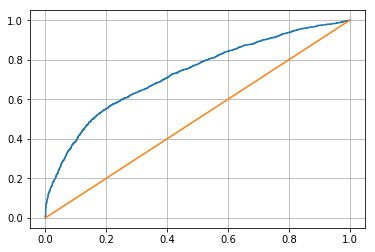


Random Forest
5-fold CV f1 = 0.680956801273673, std = 0.011802719666370679
5-fold CV ROC AUC = 0.7851289592647437, std = 0.005901317057693066
5-fold CV P = 0.739027950511848, std = 0.007283697597917587
5-fold CV R = 0.6314263011521654, std = 0.015525697974160497
example CM = [[2812  653]
 [1143 2002]]


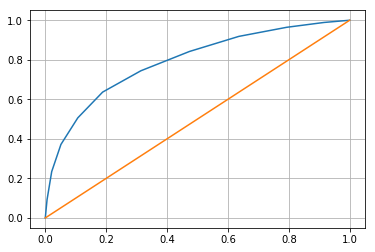

In [37]:
score_dataset(dataset, Next_cols)

## delta

In [53]:
for col in ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']:
    dataset[col] = dataset[col] - dataset['Next '+col]
    dataset[col + '_sq'] = (dataset[col] - dataset['Next '+col] )**2
    dataset.drop(columns='Next '+col, inplace=True)

In [54]:
sq_cols = [col for col in dataset.columns if '_sq' in col]

8
Logistic regression
5-fold CV f1 = 0.5709300338348728, std = 0.008128848455576671
5-fold CV ROC AUC = 0.6714362830730589, std = 0.006111633341478529
5-fold CV P = 0.6424227046917733, std = 0.008357678906056678
5-fold CV R = 0.5137896643049837, std = 0.008827104938571596
example CM = [[2540  925]
 [1537 1608]]


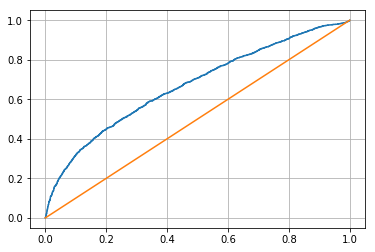


Random Forest
5-fold CV f1 = 0.6557829755652537, std = 0.006884599471098436
5-fold CV ROC AUC = 0.7590364200747761, std = 0.0040531850067364785
5-fold CV P = 0.7068651763526098, std = 0.0037499417143561494
5-fold CV R = 0.6117148067228696, std = 0.012081484170300687
example CM = [[2719  746]
 [1213 1932]]


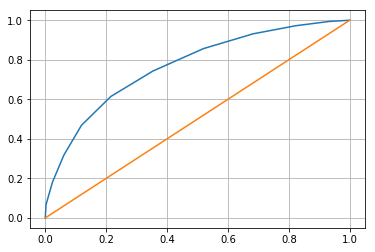

In [55]:
score_dataset(dataset, non_sq_cols)

## diff and sq diff

9
Logistic regression
5-fold CV f1 = 0.6058688003272753, std = 0.010426054806228477
5-fold CV ROC AUC = 0.7096003693562748, std = 0.007638736056513399
5-fold CV P = 0.6859091037497238, std = 0.009719481081082672
5-fold CV R = 0.5425643304385505, std = 0.010661279974608117
example CM = [[2727  738]
 [1444 1701]]


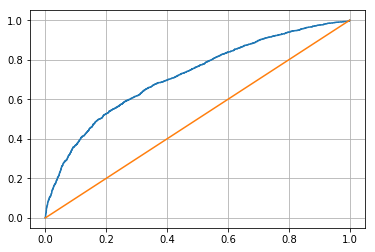


Random Forest
5-fold CV f1 = 0.6568293057839512, std = 0.007250532873412795
5-fold CV ROC AUC = 0.7625976075558611, std = 0.006330732270112517
5-fold CV P = 0.7149319226814257, std = 0.003485176542526919
5-fold CV R = 0.6075031281719916, std = 0.01007257953001015
example CM = [[2738  727]
 [1194 1951]]


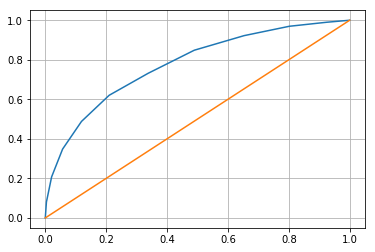

In [56]:
score_dataset(dataset)

In [57]:
non_sq_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

10
Logistic regression
5-fold CV f1 = 0.5684702675779657, std = 0.009315797114515167
5-fold CV ROC AUC = 0.6707789053190912, std = 0.006228485579037001
5-fold CV P = 0.6445529068197154, std = 0.004656958805522041
5-fold CV R = 0.5086245644087612, std = 0.014218589012265467
example CM = [[2580  885]
 [1561 1584]]


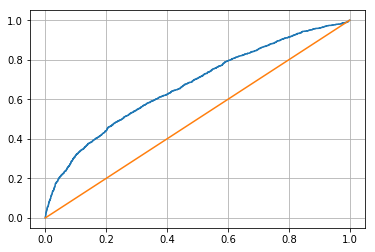


Random Forest
5-fold CV f1 = 0.646600788750569, std = 0.002636994992311606
5-fold CV ROC AUC = 0.7577237351241466, std = 0.004186572727708209
5-fold CV P = 0.7076503135229133, std = 0.006607367011598375
5-fold CV R = 0.5953422292796897, std = 0.006397620284624653
example CM = [[2711  754]
 [1164 1981]]


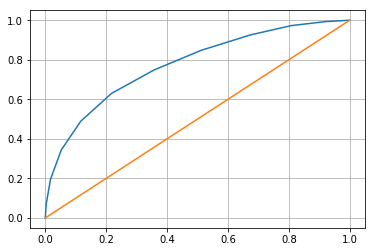

In [58]:
score_dataset(dataset, non_sq_cols)

# XGBoost

In [31]:
dataset.drop(index=dataset[dataset.Timestamp.dt.dayofweek>5].index, inplace=True)

In [32]:
drop_cols = ['y', 'Timestamp', 'IncidentID', 'Longitude', 'Latitude']
tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)

scaler = StandardScaler()
tr_X = scaler.fit_transform(tr_X)
te_X = scaler.transform(te_X)

In [118]:
tr_d = xgb.DMatrix(tr_X, label=tr_y)
te_d = xgb.DMatrix(te_X, label=te_y)

In [34]:
xgb_params = {'objective':'binary:logistic', 'learning_rate': 1.0, 'n_estimators': 500, 'min_child_weight': .1, 'max_depth': 3, 'gamma': 0, 'subsample': 1, 'colsample_bytree': 1, 'reg_lambda': 1}

clf = xgb.XGBClassifier(**xgb_params)

clf.fit(tr_X, tr_y)

prd = clf.predict(te_X)

prd = np.round(prd)

f1_score(te_y, prd)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6541143654114365

In [112]:
f1_score(te_y, prd)

0.6401273885350318

In [68]:
min_lon = dataset['Longitude'].min()
max_lon = dataset['Longitude'].max()
min_lat = dataset['Latitude'].min()
max_lat = dataset['Latitude'].max()

In [ ]:
st1_coords = (stations_active['Latitude'][0], stations_active['Longitude'][0])
st2_coords = (stations_active['Latitude'][1], stations_active['Longitude'][1])
st1_coords_ccrs = [stations_active['Latitude'][0], stations_active['Longitude'][0]]

In [76]:
drop_cols = ['y', 'Timestamp', 'IncidentID'] #, 'Longitude', 'Latitude']
tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)

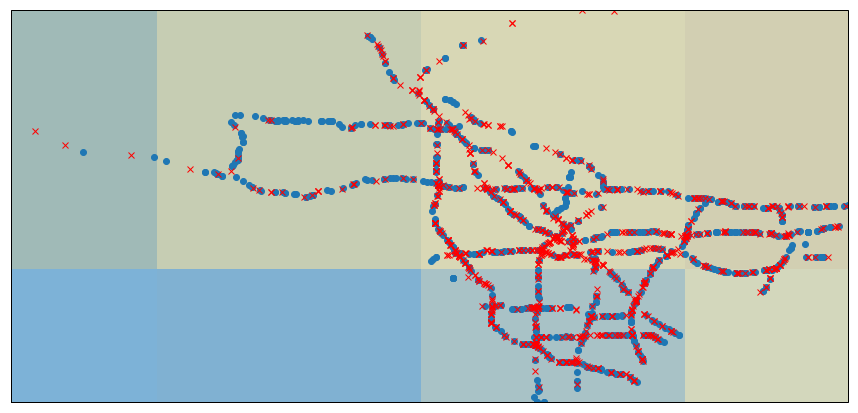

In [82]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_xlim((min_lon, max_lon))
ax.set_ylim((min_lat, max_lat))
plt.plot(te_X[te_y==0].head(1000)['Longitude'], te_X[te_y==0].head(1000)['Latitude'], transform=ccrs.PlateCarree(), marker='o', linestyle='')
plt.plot(te_X[te_y==1].head(1000)['Longitude'], te_X[te_y==1].head(1000)['Latitude'], transform=ccrs.PlateCarree(), marker='x', color='red', linestyle='')
# plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'], data_inc_d07[data_inc_d07['District']==7]['Latitude'], marker='x', color='red', linestyle='')
# plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'].mean(), data_inc_d07[data_inc_d07['District']==7]['Latitude'].mean()-.05, marker='*', markersize=10, color='black', linestyle='')
plt.show()

In [50]:
param_grid = {'objective': ['binary:logistic'], 
              'learning_rate': [1.0, .1],
              'n_estimators': [500],
             'min_child_weight' : [.1, 1, 10],
             'max_depth': [3, 6, 10],
             'gamma': [0, .1],
             'subsample': [.5, 1],
              'colsample_bytree': [.5, 1],
              'reg_lambda': [1]
             }
grdCV = GridSearchCV(clf, param_grid, 'f1', cv=5, n_jobs=-1, refit=True)

In [51]:
grdCV.fit(tr_X, tr_y)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=1.0, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['binary:logistic'], 'learning_rate': [1.0, 0.1], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [52]:
grdCV.best_score_

0.793343643429183

In [72]:
def grd_srch_boost(dataset, drop_features=[], cv=5):
    drop_cols = ['y', 'Timestamp', 'IncidentID', 'ID_Prev', 'ID_Next'] + drop_features #, 'Longitude', 'Latitude'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
        
    print('XGBoost')
    param_grid = {'objective': ['binary:logistic'], 
              'learning_rate': [1.0, .1],
              'n_estimators': [500]}
    clf = xgb.XGBClassifier(**xgb_params)
    grdCV = GridSearchCV(clf, param_grid, 'f1', cv=cv, n_jobs=-1, refit=True)
    grdCV.fit(tr_X, tr_y)
    return grdCV
    predict = clf.predict(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    proba = clf.predict_proba(te_X)
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    print()
      
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.show()
    
    print()
    


In [56]:
grd_CV = grd_srch_boost(dataset)

XGBoost


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [99]:
joblib.dump(grd_CV, 'pickle.pkl')

['pickle.pkl']

In [100]:
cl = joblib.load('pickle.pkl')

In [104]:
prd = cl.best_estimator_.predict(te_X)


/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [106]:
f1_score(te_y, prd)

0.7536160217579428

In [81]:
fignum=1
def boost(dataset, drop_features=[], cv=5):
    global fignum
    print(fignum)
    drop_cols = ['y', 'Timestamp', 'ID_Prev', 'ID_Next'] + drop_features #, 'Longitude', 'Latitude', 'IncidentID', 'ID_Prev', 'ID_Next'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2, random_state=442)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
        
    print('XGBoost')
    xgb_params = {'objective':'binary:logistic', 'learning_rate': 1.0, 'n_estimators': 500}
    clf = xgb.XGBClassifier(**xgb_params)
    cv_res = cross_validate(clf, tr_X, tr_y, n_jobs=-1, cv=cv, scoring=['f1', 'roc_auc', 'precision', 'recall']) # scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1'].mean()
    F1_var = cv_res['test_f1'].std()
    RA_score = cv_res['test_roc_auc'].mean()
    RA_var = cv_res['test_roc_auc'].std()
    P_score = cv_res['test_precision'].mean()
    P_var = cv_res['test_precision'].std()
    R_score = cv_res['test_recall'].mean()
    R_var = cv_res['test_recall'].std()
    
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    print('{}-fold CV ROC AUC = {}, std = {}'.format(cv, RA_score, RA_var))
    print('{}-fold CV P = {}, std = {}'.format(cv, P_score, P_var))
    print('{}-fold CV R = {}, std = {}'.format(cv, R_score, R_var))
    clf.fit(tr_X, tr_y)
    predict = clf.predict(te_X)
    proba = clf.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0,1], [0,1], label='reference', linestyle='--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.grid()
    plt.legend()
    plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/roc_auc_{}'.format(fignum), lw=4, dpi=600)
    plt.show()
    fignum += 1
    return clf, fpr, tpr

In [16]:
for c in dataset.columns:
    print('\'' + c + '\',')

'ID_Prev',
'ID_Next',
'Timestamp',
'Latitude_Next',
'Longitude_Next',
'Latitude_Prev',
'Longitude_Prev',
'Avg Occupancy_0',
'Avg Occupancy_1',
'Avg Occupancy_2',
'Avg Occupancy_3',
'Avg Occupancy_4',
'Avg Occupancy_5',
'Avg Occupancy_6',
'Avg Occupancy_7',
'Avg Occupancy_8',
'Avg Occupancy_9',
'Avg Occupancy_10',
'Avg Occupancy_11',
'Avg Occupancy_12',
'Avg Occupancy_13',
'Avg Occupancy_14',
'Avg Occupancy_15',
'Total Flow_0',
'Total Flow_1',
'Total Flow_2',
'Total Flow_3',
'Total Flow_4',
'Total Flow_5',
'Total Flow_6',
'Total Flow_7',
'Total Flow_8',
'Total Flow_9',
'Total Flow_10',
'Total Flow_11',
'Total Flow_12',
'Total Flow_13',
'Total Flow_14',
'Total Flow_15',
'Avg Speed_0',
'Avg Speed_1',
'Avg Speed_2',
'Avg Speed_3',
'Avg Speed_4',
'Avg Speed_5',
'Avg Speed_6',
'Avg Speed_7',
'Avg Speed_8',
'Avg Speed_9',
'Avg Speed_10',
'Avg Speed_11',
'Avg Speed_12',
'Avg Speed_13',
'Avg Speed_14',
'Avg Speed_15',
'Next Avg Occupancy_0',
'Next Avg Occupancy_1',
'Next Avg Occupancy_2',
'Next

In [83]:
Next_cols = ['Next Avg Occupancy_0','Next Avg Occupancy_1','Next Avg Occupancy_2',
             'Next Avg Occupancy_3','Next Avg Occupancy_4','Next Avg Occupancy_5',
             'Next Avg Occupancy_6','Next Avg Occupancy_7','Next Avg Occupancy_8',
             'Next Avg Occupancy_9','Next Avg Occupancy_10','Next Avg Occupancy_11',
             'Next Avg Occupancy_12','Next Avg Occupancy_13','Next Avg Occupancy_14',
             'Next Avg Occupancy_15','Next Total Flow_0','Next Total Flow_1',
             'Next Total Flow_2','Next Total Flow_3','Next Total Flow_4',
             'Next Total Flow_5','Next Total Flow_6','Next Total Flow_7',
             'Next Total Flow_8','Next Total Flow_9','Next Total Flow_10',
             'Next Total Flow_11','Next Total Flow_12','Next Total Flow_13',
             'Next Total Flow_14','Next Total Flow_15','Next Avg Speed_0',
             'Next Avg Speed_1','Next Avg Speed_2','Next Avg Speed_3',
             'Next Avg Speed_4','Next Avg Speed_5','Next Avg Speed_6',
             'Next Avg Speed_7','Next Avg Speed_8','Next Avg Speed_9',
             'Next Avg Speed_10','Next Avg Speed_11','Next Avg Speed_12',
             'Next Avg Speed_13','Next Avg Speed_14','Next Avg Speed_15']

In [ ]:
extr_clf, extr_fpr, extr_tpr = boost(dataset)

1


1
XGBoost
5-fold CV f1 = 0.72579756470484, std = 0.0069076156577848324
5-fold CV ROC AUC = 0.8158489710282026, std = 0.006113120496062834
5-fold CV P = 0.7298468659609633, std = 0.0054217084935130255
5-fold CV R = 0.7218037219719895, std = 0.008553080040592865
example CM = [[2579  886]
 [ 824 2321]]


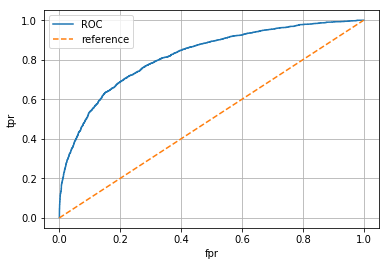

In [82]:
all_clf, all_fpr, all_tpr = boost(dataset)

2
XGBoost
5-fold CV f1 = 0.7309596722996374, std = 0.008368812268683272
5-fold CV ROC AUC = 0.8194023516025467, std = 0.006418962544160065
5-fold CV P = 0.733242975055812, std = 0.009361881112749767
5-fold CV R = 0.7287189559327258, std = 0.008565643778659785
example CM = [[2646  819]
 [ 769 2376]]


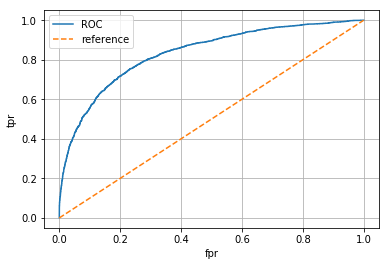

In [84]:
nonext_clf, nonext_fpr, nonext_tpr = boost(dataset, Next_cols)

In [97]:
for col in ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']:
    dataset[col] = dataset[col] - dataset['Next '+col]
    dataset[col + '_sq'] = (dataset[col] - dataset['Next '+col] )**2
    dataset.drop(columns='Next '+col, inplace=True)

In [98]:
sq_cols = [col for col in dataset.columns if '_sq' in col]

In [99]:
non_sq_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

5
XGBoost
5-fold CV f1 = 0.7154427154094204, std = 0.004517559782526669
5-fold CV ROC AUC = 0.803517496235186, std = 0.003723267461632962
5-fold CV P = 0.7201476955472144, std = 0.006206737169332737
5-fold CV R = 0.7108340233944945, std = 0.005317443392451376
example CM = [[2550  915]
 [ 856 2289]]


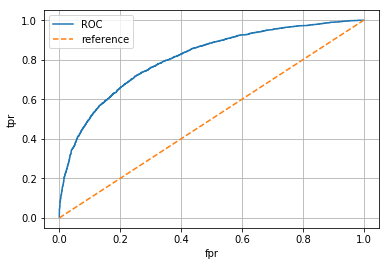

In [100]:
dfr_clf, dfr_fpr, dfr_tpr = boost(dataset)

3
XGBoost
5-fold CV f1 = 0.7090167601025206, std = 0.004748938900016864
5-fold CV ROC AUC = 0.7990703981036588, std = 0.0036745201971568487
5-fold CV P = 0.7112110432966067, std = 0.009469343793543845
5-fold CV R = 0.7069393939968153, std = 0.005409983177634967
example CM = [[2616  849]
 [ 905 2240]]


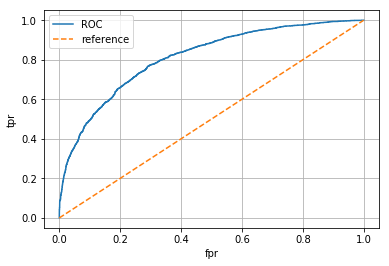

In [518]:
sqd_clf, sqd_fpr, sqd_tpr = boost(dataset, non_sq_cols)

In [93]:
ext_fpr = np.loadtxt('../data/PeMS/Incidents/work_folder/figs/xgb/extr_fpr.csv')

In [95]:
ext_tpr = np.loadtxt('../data/PeMS/Incidents/work_folder/figs/xgb/extr_tpr.csv')

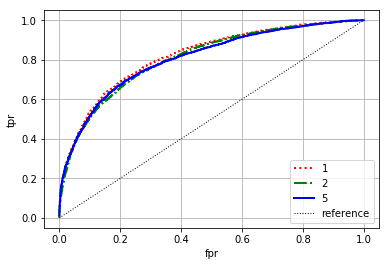

In [101]:
# plt.plot(fpr_m10, tpr_m10, label='5 min', linestyle='-', lw=2)
plt.plot(all_fpr, all_tpr, label='1', linestyle=':', lw=2, color='r')
plt.plot(dfr_fpr, dfr_tpr, label='2', linestyle='-.', lw=2, color='g')
# plt.plot(dfr_fpr, dfr_tpr, label='3', linestyle='--', lw=2, color='b')
# plt.plot(sqd_fpr, sqd_tpr, label='4', linestyle='-', lw=2, color='y')
plt.plot(ext_fpr, ext_tpr, label='5', linestyle='-', lw=2, color='b')
plt.plot([0,1], [0,1], label='reference', linestyle=':', lw=1, color='black')
plt.grid()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_cmpr.png', lw=4, dpi=600)
plt.show()

In [85]:
def crop_window(dataset, mins):
    min_later = np.array([], dtype=str)
    for cc in dataset.columns:
        if 'Avg' in cc or 'Tot' in cc:
            if int(cc.split('_')[-1])>=8+int(mins/5):
                min_later = np.append(min_later, cc)
    return min_later

In [109]:
min_later_m40 = crop_window(dataset, -40)

In [143]:
min_later_m10 = crop_window(dataset, -10)

In [86]:
min_later10 = crop_window(dataset, 10)

In [41]:
min_later20 = crop_window(dataset, 20)

In [42]:
min_later30 = crop_window(dataset, 30)

7
XGBoost
5-fold CV f1 = 0.7538689184123276, std = 0.00400826625400692
5-fold CV ROC AUC = 0.8418700781074074, std = 0.00384545148977873
5-fold CV P = 0.7340320339203639, std = 0.0029899140283699836
5-fold CV R = 0.774818894474647, std = 0.005746102920707598
example CM = [[2637  828]
 [ 687 2458]]


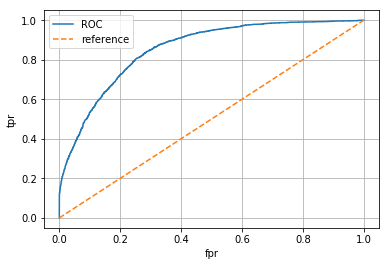

In [112]:
clf_m40, fpr_m40, tpr_m40 = boost(dataset, [cc for cc in min_later_m40])

4
XGBoost
5-fold CV f1 = 0.7187309808410697, std = 0.014112289568393136
5-fold CV ROC AUC = 0.806577914274056, std = 0.01147964210395223
5-fold CV P = 0.7206137493654262, std = 0.012766586073496308
5-fold CV R = 0.716876369463483, std = 0.015746491499598336
example CM = [[2630  835]
 [ 843 2302]]


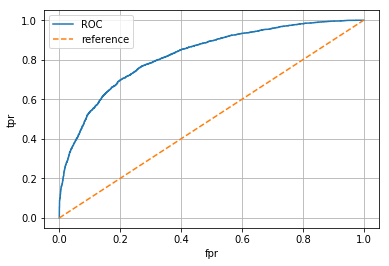

In [89]:
clf10, fpr10, tpr10 = boost(dataset, [cc for cc in min_later10])

3
XGBoost
5-fold CV f1 = 0.7226684062379709, std = 0.007182678720133726
5-fold CV ROC AUC = 0.8112073435897444, std = 0.00613028216398211
5-fold CV P = 0.7307464388143007, std = 0.007438026662053484
5-fold CV R = 0.7148073229227265, std = 0.008772431365494212
example CM = [[2589  876]
 [ 845 2300]]


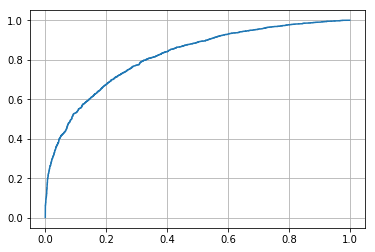

In [288]:
clf20, fpr20, tpr20 = boost(dataset, [cc for cc in min_later20])

4
XGBoost
5-fold CV f1 = 0.7204322858265885, std = 0.005251306930724414
5-fold CV ROC AUC = 0.8082908833546615, std = 0.006702830699474781
5-fold CV P = 0.7239944276558931, std = 0.004840055240904652
5-fold CV R = 0.7169546606130774, std = 0.008194032393832887
example CM = [[2671  794]
 [ 826 2319]]


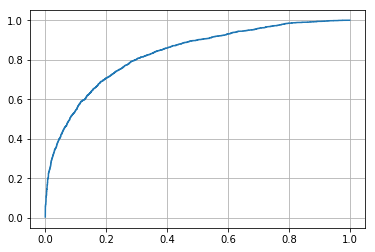

In [289]:
clf30, fpr30, tpr30 = boost(dataset, [cc for cc in min_later30])

1
XGBoost
5-fold CV f1 = 0.7273758672287028, std = 0.007365092372188869
5-fold CV ROC AUC = 0.8156865481769587, std = 0.0053353588694147365
5-fold CV P = 0.7304146532606898, std = 0.006211752246463319
5-fold CV R = 0.7244258280576026, std = 0.010746423370139436
example CM = [[2699  766]
 [ 893 2252]]


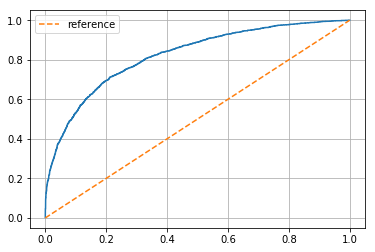

In [332]:
clf40, fpr40, tpr40 = boost(dataset)

In [336]:
np.random.seed=442
trX,testX,trY,testY = train_test_split(dataset.drop(columns=['y', 'Timestamp', 'ID_Prev', 'ID_Next'] ), dataset['y'], stratify=dataset.y, test_size=.2, random_state=442)
scaler = StandardScaler()
tr_X = scaler.fit_transform(trX)
testX = scaler.transform(testX)

In [337]:
ped = clf40.predict(testX)

In [439]:
ftr_imp = pd.DataFrame(np.hstack((dataset.drop(columns=['y', 'Timestamp', 'ID_Prev', 'ID_Next'] ).columns[:,np.newaxis],clf40.feature_importances_[:,np.newaxis])), columns=['feature', 'importance'])

In [67]:
def col_mapper(col):
    if 'Tot' in col or 'Avg' in col:
        vals = col.split('_')
        nbr = int(vals[-1])*5-40
        return vals[0]+' @'+str(nbr)+'\'' if 'Next' in col else 'Prev '+vals[0]+' @'+str(nbr)+'\''
    else:
        if 'Next' in col:
            parts = col.split('_')
            return 'Next ' + parts[0]
        if 'Prev' in col:
            parts = col.split('_')
            return 'Prev ' + parts[0]
        else:
            return col

In [542]:
ftr_imp = pd.DataFrame(np.hstack((dataset.drop(columns=['y', 'Timestamp', 'ID_Prev', 'ID_Next'] ).columns[:,np.newaxis],clf40.feature_importances_[:,np.newaxis])), columns=['feature', 'importance'])
ftr_imp['feature']=ftr_imp.feature.apply(col_mapper)

rmapp = {key:col_mapper(key) for key in dataset.columns}

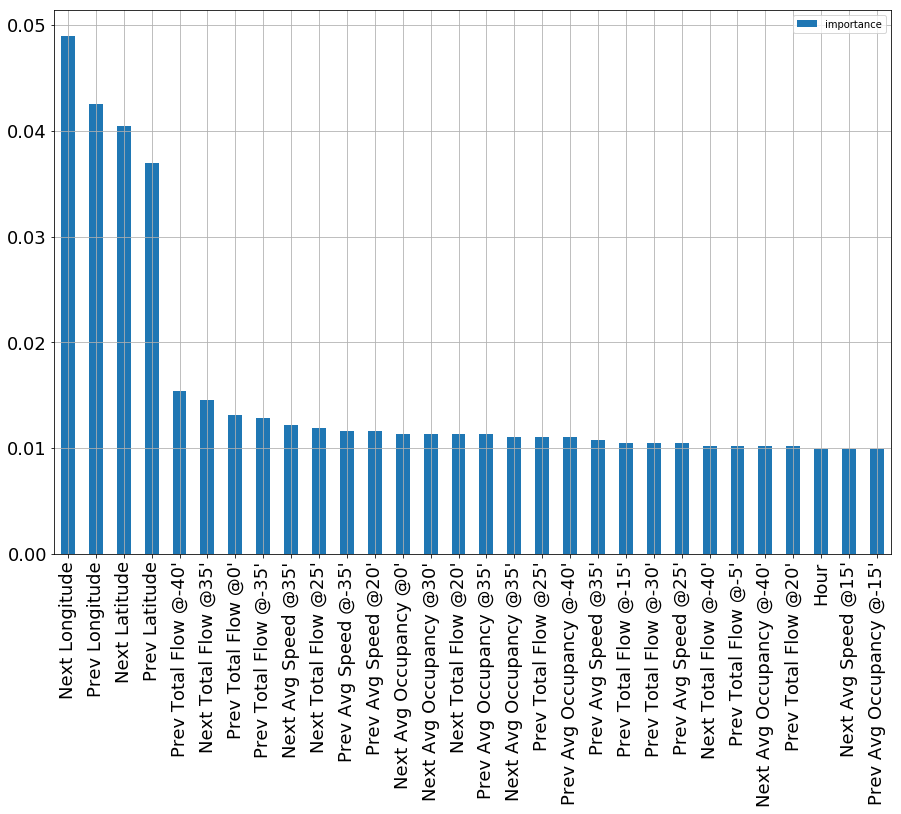

In [563]:
# plt.figure()
# top = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30)
# plt.figure(figsize=[15,10])
ax = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30).plot.bar(x='feature', figsize=[15,10], grid=True, fontsize=18)
# plt.bar(x=top['feature'], height=top['importance'])
plt.xlabel('')
# ax.get_figure().savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')
plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')

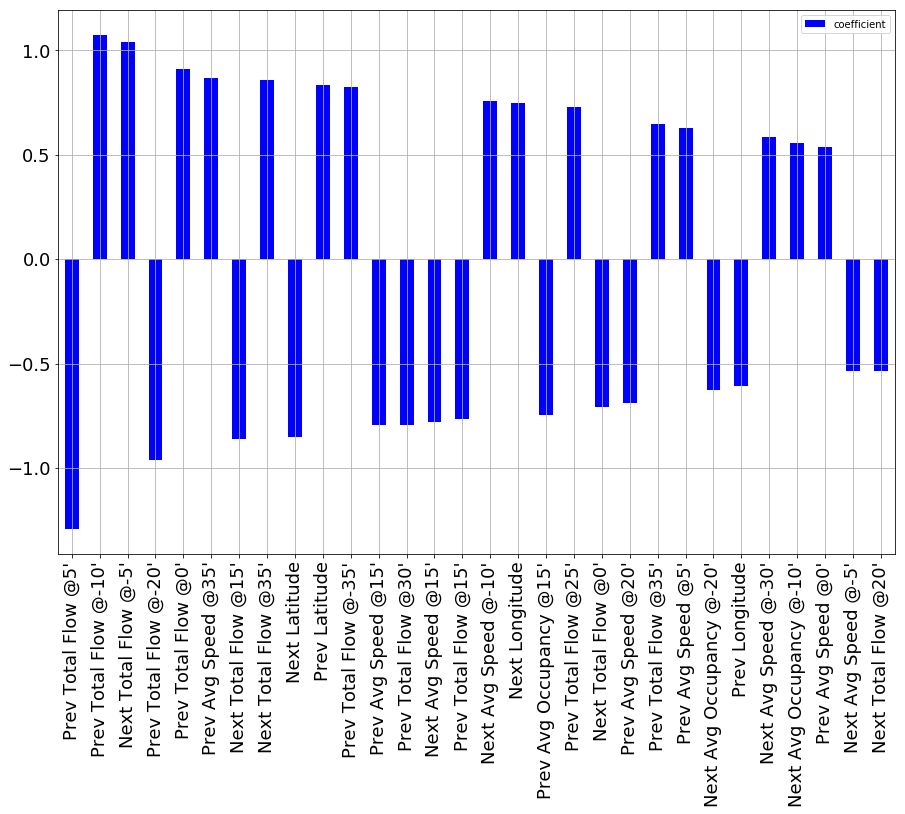

In [80]:
ftr_imp = pd.DataFrame(np.hstack((dataset.drop(columns=['y', 'Timestamp', 'ID_Prev', 'ID_Next'] ).columns[:,np.newaxis],clf.coef_.flatten()[:,np.newaxis])), columns=['feature', 'coefficient'])
ftr_imp['feature']=ftr_imp.feature.apply(col_mapper)
ftr_imp['abs']=np.abs(ftr_imp['coefficient'])

rmapp = {key:col_mapper(key) for key in dataset.columns}

# plt.figure()
# top = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30)
# plt.figure(figsize=[15,10])
ax = ftr_imp.rename(rmapp).sort_values(by='abs', ascending=False).head(30).plot.bar(x='feature', y='coefficient', figsize=[15,10], grid=True, fontsize=18, color='b')
# plt.bar(x=top['feature'], height=top['importance'])
plt.xlabel('')
# ax.get_figure().savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')
plt.savefig('../data/PeMS/Incidents/work_folder/figs/log/ftr_imp.png', lw=4, dpi=600, bbox_inches='tight')

2
XGBoost
5-fold CV f1 = 0.6884398286264815, std = 0.007018360197893905
5-fold CV ROC AUC = 0.7731120934322486, std = 0.006547796947317664
5-fold CV P = 0.6863462494014605, std = 0.008123465676352498
5-fold CV R = 0.6905653637932962, std = 0.006713732656816016
example CM = [[2542  923]
 [ 937 2208]]


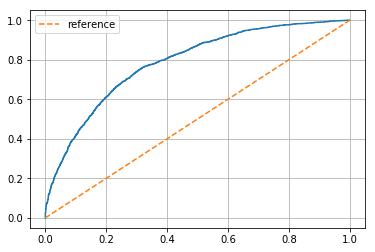

In [293]:
min_later_m10 = crop_window(dataset, -10)
fpr_m10, tpr_m10 = boost(dataset, [cc for cc in min_later_m10])

In [ ]:
fpr_m40

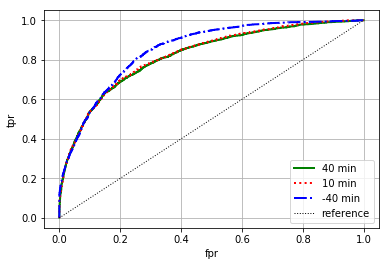

In [157]:
# plt.plot(fpr_m10, tpr_m10, label='5 min', linestyle='-', lw=2)
plt.plot(all_fpr, all_tpr, label='40 min', linestyle='-', lw=2, color='g')
plt.plot(fpr10, tpr10, label='10 min', linestyle=':', lw=2, color='r')
# plt.plot(fpr20, tpr20, label='20 min', linestyle='-.', lw=2, color='g')
# plt.plot(fpr30, tpr30, label='30 min', linestyle='--', lw=2, color='b')
plt.plot(fpr_m40, tpr_m40, label='-40 min', linestyle='-.', lw=2, color='b')
plt.plot([0,1], [0,1], label='reference', linestyle=':', lw=1, color='black')
plt.grid()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/roc_auc_sizes.png', lw=4, dpi=600)
plt.show()

In [569]:
extr = pd.read_csv('../data/PeMS/Incidents/work_folder/extracted_32000.csv')

In [570]:
for c in extr.columns:
    if 'Next' in c:
        print('yes')
        break

yes


In [116]:
non_loc_clf = joblib.load('pickle_wo_loc.pkl')

In [117]:
drop_cols = ['y', 'Timestamp', 'Latitude_Next', 'Longitude_Next', 'Latitude_Prev', 'Longitude_Prev'] #, 'Longitude', 'Latitude'
tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2, random_state=442)
scaler = StandardScaler()
tr_X = scaler.fit_transform(tr_X)
te_X = scaler.transform(te_X)

In [127]:
prd = non_loc_clf.predict(te_X)

f1 = 0.9285947179654385
ROC AUC = 0.9324358736123441
P = 0.9528270324523251
R = 0.9055643879173291
example CM = [[3324  141]
 [ 297 2848]]


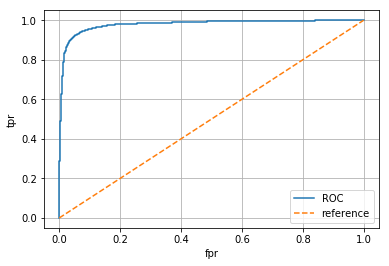

In [128]:
F1_score = f1_score(te_y, prd)
RA_score = roc_auc_score(te_y, prd)
P_score = precision_score(te_y, prd)
R_score = recall_score(te_y, prd)

print('f1 = {}'.format( F1_score))
print('ROC AUC = {}'.format( RA_score))
print('P = {}'.format( P_score))
print('R = {}'.format( R_score))


proba = non_loc_clf.predict_proba(te_X)
print('example CM =', confusion_matrix(te_y, prd))
fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1], [0,1], label='reference', linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.grid()
plt.legend()
plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/roc_auc_{}'.format(fignum), lw=4, dpi=600)
plt.show()

In [131]:
non_loc_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=nan, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
dataset.ID_Next

In [132]:
ftr_imp = pd.DataFrame(np.hstack((dataset.drop(columns=['y', 'Timestamp', 'Latitude_Next', 'Longitude_Next', 'Latitude_Prev', 'Longitude_Prev'] ).columns[:,np.newaxis],non_loc_clf.best_estimator_.feature_importances_[:,np.newaxis])), columns=['feature', 'importance'])
ftr_imp['feature']=ftr_imp.feature.apply(col_mapper)
rmapp = {key:col_mapper(key) for key in dataset.columns}

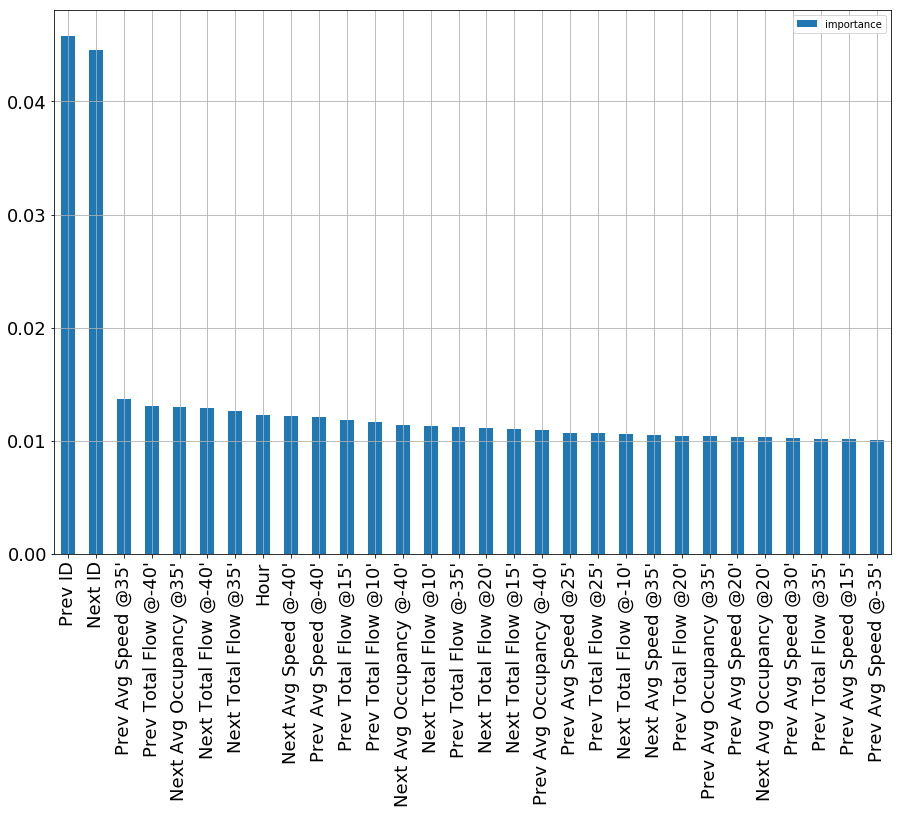

In [133]:
# plt.figure()
# top = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30)
# plt.figure(figsize=[15,10])
ax = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30).plot.bar(x='feature', figsize=[15,10], grid=True, fontsize=18)
# plt.bar(x=top['feature'], height=top['importance'])
plt.xlabel('')
# ax.get_figure().savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')
plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')